In [1]:
import numpy as np
import pandas as pd
import biogeme
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

# RUM

In [2]:
%run -i "binary_specific_netherlands.py"

                 Value  Std err  t-test  p-value  Rob. Std err  Rob. t-test  \
ASC_CAR           2.95     1.33    2.21   0.0269          1.35         2.18   
BETA_COST_CAR   -0.118   0.0314   -3.75 0.000174        0.0388        -3.04   
BETA_COST_RAIL -0.0775   0.0433   -1.79   0.0737        0.0462        -1.68   
BETA_TT_CAR      -2.25     0.52   -4.32 1.56e-05         0.494        -4.55   
BETA_TT_RAIL    -0.605    0.498   -1.21    0.225          0.48        -1.26   

                Rob. p-value  
ASC_CAR               0.0296  
BETA_COST_CAR        0.00236  
BETA_COST_RAIL        0.0934  
BETA_TT_CAR         5.29e-06  
BETA_TT_RAIL           0.208  
Nbr of observations: 178
LL(0) =    -93.804
LL(beta) = -93.804
rho bar square = -0.0533
Output file: None
Predicted   0   1
Actual           
0          29   3
1           8  10
Global accuracy of the model: 0.78


In [3]:
BETA_COST_CAR = pandasResults.loc['BETA_COST_CAR', 'Value']
BETA_COST_RAIL = pandasResults.loc['BETA_COST_RAIL', 'Value']
BETA_TT_CAR = pandasResults.loc['BETA_TT_CAR', 'Value']
BETA_TT_RAIL = pandasResults.loc['BETA_TT_RAIL', 'Value']

# Constrained GBM

In [4]:
ned_data_rp = pd.read_table("Data/netherlandsRP.dat")

X = ned_data_rp[['car_cost', 'rail_cost', 'car_ivtt', 'car_walk_time', 'rail_ivtt', 'rail_acc_time', 'rail_egr_time']]
X_updt = X.copy()
X_updt['car_tt'] = X['car_ivtt'] +X['car_walk_time']
X_updt['rail_tt'] = X['rail_ivtt'] +X['rail_acc_time'] +X['rail_egr_time']

rate_G2E = 0.44378022
X_updt['car_cost'] = X_updt['car_cost'] * rate_G2E
X_updt['rail_cost'] = X_updt['rail_cost'] * rate_G2E
X_updt = X_updt.drop(columns=['car_ivtt', 'car_walk_time', 'rail_ivtt', 'rail_acc_time', 'rail_egr_time'])

y = ned_data_rp['choice']

In [5]:
X_train, X_validate, y_train, y_validate = train_test_split(X_updt, y, test_size=0.2, random_state=42)

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_validate, label=y_validate)

evallist = [(dtrain, 'train'), (deval, 'eval')]

num_round = 100

param = {'max_depth': 1, 
         'objective': 'binary:logistic', 
         'lambda':0, 
         'alpha':0, 
         'monotone_constraints': (-1, -1, -1, -1), 
         'interaction_constraints': [["car_cost"], ["rail_cost"], ["car_tt"], ["rail_tt"]]}

In [7]:
xgb_constrained = xgb.train(param, dtrain, num_round, evallist)

[0]	train-logloss:0.65805	eval-logloss:0.69125
[1]	train-logloss:0.63799	eval-logloss:0.68585
[2]	train-logloss:0.62675	eval-logloss:0.69093
[3]	train-logloss:0.61956	eval-logloss:0.68191
[4]	train-logloss:0.61520	eval-logloss:0.68267
[5]	train-logloss:0.61200	eval-logloss:0.68775
[6]	train-logloss:0.60998	eval-logloss:0.69406
[7]	train-logloss:0.60859	eval-logloss:0.68927
[8]	train-logloss:0.60750	eval-logloss:0.69277
[9]	train-logloss:0.60669	eval-logloss:0.69290
[10]	train-logloss:0.60617	eval-logloss:0.69548
[11]	train-logloss:0.60579	eval-logloss:0.69266
[12]	train-logloss:0.60548	eval-logloss:0.69525
[13]	train-logloss:0.60525	eval-logloss:0.69527
[14]	train-logloss:0.60508	eval-logloss:0.69678
[15]	train-logloss:0.60497	eval-logloss:0.69519
[16]	train-logloss:0.60489	eval-logloss:0.69655
[17]	train-logloss:0.60482	eval-logloss:0.69655
[18]	train-logloss:0.60476	eval-logloss:0.69744
[19]	train-logloss:0.60472	eval-logloss:0.69830
[20]	train-logloss:0.60469	eval-logloss:0.69830
[2

C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[66]	train-logloss:0.60451	eval-logloss:0.70377
[67]	train-logloss:0.60451	eval-logloss:0.70380
[68]	train-logloss:0.60451	eval-logloss:0.70381
[69]	train-logloss:0.60451	eval-logloss:0.70384
[70]	train-logloss:0.60451	eval-logloss:0.70387
[71]	train-logloss:0.60451	eval-logloss:0.70389
[72]	train-logloss:0.60451	eval-logloss:0.70390
[73]	train-logloss:0.60451	eval-logloss:0.70388
[74]	train-logloss:0.60451	eval-logloss:0.70390
[75]	train-logloss:0.60451	eval-logloss:0.70391
[76]	train-logloss:0.60451	eval-logloss:0.70392
[77]	train-logloss:0.60451	eval-logloss:0.70392
[78]	train-logloss:0.60451	eval-logloss:0.70393
[79]	train-logloss:0.60451	eval-logloss:0.70394
[80]	train-logloss:0.60451	eval-logloss:0.70396
[81]	train-logloss:0.60451	eval-logloss:0.70397
[82]	train-logloss:0.60451	eval-logloss:0.70397
[83]	train-logloss:0.60451	eval-logloss:0.70398
[84]	train-logloss:0.60451	eval-logloss:0.70399
[85]	train-logloss:0.60451	eval-logloss:0.70398
[86]	train-logloss:0.60451	eval-logloss:

In [8]:
dtest = xgb.DMatrix(X_validate)

y_pred=np.rint(xgb_constrained.predict(dtest))

from sklearn.metrics import accuracy_score

accuracy_score(y_validate, y_pred)

0.5869565217391305

# Unconstrained model

In [9]:
num_round = 100

param_unc = {'max_depth': 1, 
         'objective': 'binary:logistic', 
         'lambda':0, 
         'alpha':0}

In [10]:
xgb_unconstrained = xgb.train(param_unc, dtrain, num_round, evallist)

[0]	train-logloss:0.62675	eval-logloss:0.66602
[1]	train-logloss:0.59312	eval-logloss:0.66133
[2]	train-logloss:0.57094	eval-logloss:0.65875
[3]	train-logloss:0.55179	eval-logloss:0.63835
[4]	train-logloss:0.53972	eval-logloss:0.62752
[5]	train-logloss:0.52912	eval-logloss:0.62456
[6]	train-logloss:0.51979	eval-logloss:0.61042
[7]	train-logloss:0.51170	eval-logloss:0.59741
[8]	train-logloss:0.50405	eval-logloss:0.60069
[9]	train-logloss:0.49708	eval-logloss:0.60261
[10]	train-logloss:0.49076	eval-logloss:0.59507
[11]	train-logloss:0.48491	eval-logloss:0.60402
[12]	train-logloss:0.47963	eval-logloss:0.59494
[13]	train-logloss:0.47546	eval-logloss:0.59807
[14]	train-logloss:0.47144	eval-logloss:0.59192
[15]	train-logloss:0.46747	eval-logloss:0.59109
[16]	train-logloss:0.46392	eval-logloss:0.58560
[17]	train-logloss:0.46057	eval-logloss:0.57516
[18]	train-logloss:0.45736	eval-logloss:0.58176
[19]	train-logloss:0.45458	eval-logloss:0.58442
[20]	train-logloss:0.45217	eval-logloss:0.58083
[2

C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [11]:
dtest = xgb.DMatrix(X_validate)

y_pred_unc=np.rint(xgb_unconstrained.predict(dtest))

accuracy_score(y_validate, y_pred_unc)

0.6956521739130435

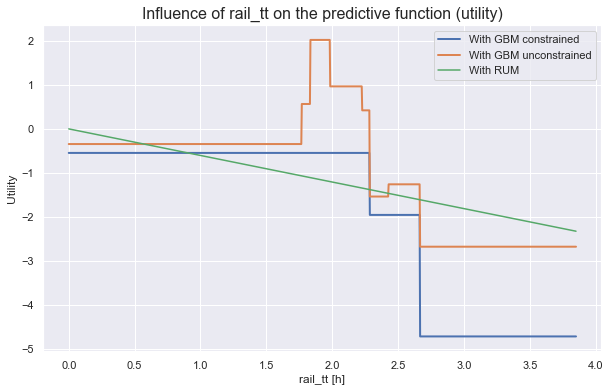

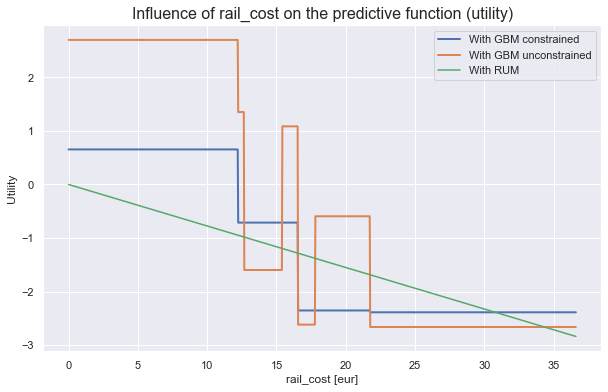

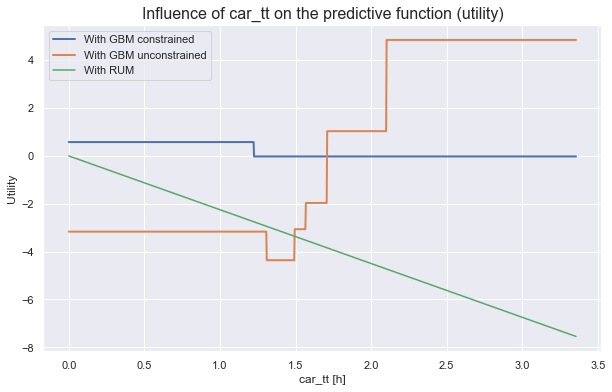

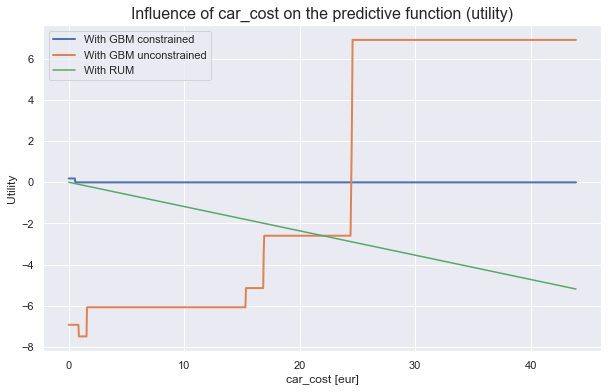

In [12]:
from NonlinearUtilityFunction import plotHisto

plotHisto(xgb_constrained, X_updt, ['h', 'eur', 'h', 'eur'], Betas = [BETA_TT_RAIL, BETA_COST_RAIL, BETA_TT_CAR, BETA_COST_CAR], model_unconstrained =xgb_unconstrained)

In [21]:
X_train.corr()

,car_cost,rail_cost,car_tt,rail_tt
car_cost,1,0.106,0.0019,-0.0177
rail_cost,0.106,1,0.0158,0.328
car_tt,0.0019,0.0158,1,0.124
rail_tt,-0.0177,0.328,0.124,1


In [22]:
import xgbfir

xgbfir.saveXgbFI(xgb_constrained, OutputXlsxFile='Not_modified.xlsx')

# Sanity check

In [ ]:
f1 = np.arange(0, 1000, 2)

ch1 = np.random.uniform(low = 0.8, high = 1, size= 100)
ch2 = np.random.uniform(low = 0.6, high = 0.8, size= 100)
ch3 = np.random.uniform(low = 0.4, high = 0.6, size= 100)
ch4 = np.random.uniform(low = 0.2, high = 0.4, size= 100)
ch5 = np.random.uniform(low = 0, high = 0.2, size= 100)

ch_prob = np.concatenate((ch1, ch2, ch3, ch4, ch5), axis = None) 

ch_logistic = np.random.logistic(ch_prob)

ch_ex = np.where(ch_logistic < 0.5, 0, 1)

ex_data_dic = {'feature_1': f1[::-1],'choice': ch_ex[::-1]}

ex_data_df = pd.DataFrame(ex_data_dic)
ex_X = ex_data_df[['feature_1']]
ex_y = ex_data_df[['choice']]

In [ ]:
xgb_ex = xgb.XGBClassifier(#objective='binary:logistic', 
                                    #learning_rate = 0.2,
                                    n_estimators = 100, 
                                    max_depth = 1, 
                                    random_state = 1,
                                    monotone_constraints = {"feature_1":-1})
                                    #interaction_constraints = [["feature_1"], ["feature_2"]]
                               

In [ ]:
xgb_ex.fit(ex_X, ex_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints={'feature_1': -1}, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=1, ...)

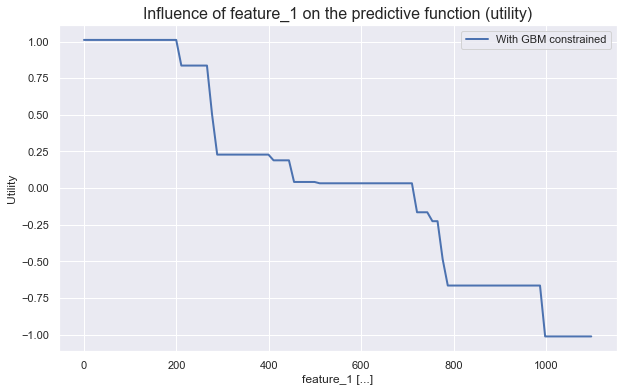

In [30]:
plotHisto(xgb_ex, ex_X, ['...'])

In [56]:
import xgbfir

xgbfir.saveXgbFI(xgb_ex, OutputXlsxFile='small_example.xlsx')